# Resumen
En Python `Threading` y `Multiprocessing` son herramientas increíblemente útiles, sin embargo en algunas ocasiones suelen ser confundidas, algunos desarrolladores no entienden muy bien cuando usar una técnica o la otra, en este post codificaremos unos casos de ejemplos para comparar el rendimiento, explicaremos el por qué de esos resultados, exploraremos algunas ventajas que tienen una sobre la otra e intentaremos hacer una lista de recomendación para saber cual usar en nuestras implementaciones. **Este NO es un tutorial de cómo usar Threads en Python**.

# Tareas

Lo mas seguro es que si eres un desarrollador Python estés mas familiarizado con los hilos (threads) que con los procesos, es muy probable que lo primero que se nos venga a la cabeza al momento pensar en un hilo es en una forma de «ejecutar múltiples tareas al mismo tiempo», entonces comencemos definiendo una tarea sencilla.

In [3]:
def long_funtion(n=10000000):
    k = 0
    for i in range(n):
        k += i

Básicamente tenemos una función se toma unos cuantos segundos en ejecutare por completo, es importante que esta función siempre esté haciendo algo, por ese motivo no hay `sleeps()` en ella.

In [4]:
long_funtion()

Podemos calcular el tiempo que tarda en ejecutarse de una forma muy sencilla:

In [5]:
import time

t0 = time.time()
long_funtion()
t1 = time.time()

print(f"{t1-t0:.3f} seconds")

0.618 seconds


Ahora, si hacemos múltiples llamados el tiempo crecerá (como es de esperarse) de forma lineal con pendiente constante.

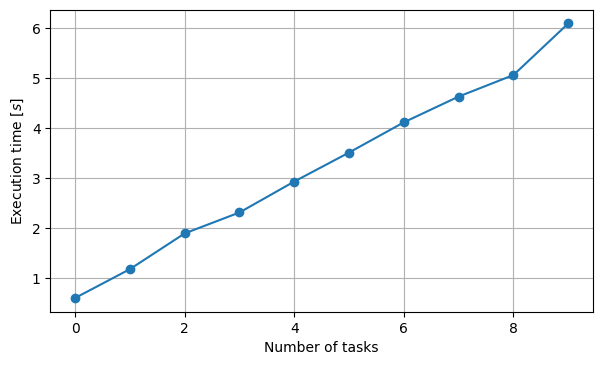

In [6]:
from matplotlib import pyplot as plt

calls = []

for i in range(1, 11):
    t0 = time.time()
    for _ in range(i):
        long_funtion()
    t1 = time.time()
    calls.append(t1-t0)
    
plt.figure(figsize=(7, 4), dpi=100)
plt.plot(calls, '-o')
plt.grid(True)
plt.xlabel('Number of tasks')
plt.ylabel('Execution time [$s$]')
plt.show()

Antes de continuar vamos a reescribir la tarea para que podamos asignarle una etiqueta y que nos imprima cuando comienza y cuando termina, además queremos que nos imprima cada `1000000` iteraciones el porcentaje de avance.

In [7]:
def long_funtion(n=10000000, label=None):
    if label:
        print(f"+start {label}")
    k = 0
    for i in range(1, n):
        k += i
        if label and not i%1000000:
            print(f"  {label} {i*100//n}%")
    if label:
        print(f"-end {label}")

In [8]:
t0 = time.time()
long_funtion(label='function-1')
long_funtion(label='function-2')
long_funtion(label='function-3')
long_funtion(label='function-4')
t1 = time.time()

print(f"{t1-t0:.3f} seconds")

+start function-1
  function-1 10%
  function-1 20%
  function-1 30%
  function-1 40%
  function-1 50%
  function-1 60%
  function-1 70%
  function-1 80%
  function-1 90%
-end function-1
+start function-2
  function-2 10%
  function-2 20%
  function-2 30%
  function-2 40%
  function-2 50%
  function-2 60%
  function-2 70%
  function-2 80%
  function-2 90%
-end function-2
+start function-3
  function-3 10%
  function-3 20%
  function-3 30%
  function-3 40%
  function-3 50%
  function-3 60%
  function-3 70%
  function-3 80%
  function-3 90%
-end function-3
+start function-4
  function-4 10%
  function-4 20%
  function-4 30%
  function-4 40%
  function-4 50%
  function-4 60%
  function-4 70%
  function-4 80%
  function-4 90%
-end function-4
5.033 seconds


Como podemos ver se ejecutaron de forma consecutiva, hasta no terminar una no empezaba con la siguiente.

## Threading

Si implementamos lo mismo pero haciendo uso de hilos nos quedaría un código como el siguiente, la funcionalidad de llamar a `join()` es para esperar a que terminen los 4 llamados.

In [9]:
from threading import Thread

t0 = time.time()

stuffs = [Thread(target=long_funtion, kwargs={'label':f'function-{i}'}) for i in range(4)]
[stuf.start() for stuf in stuffs]
[stuf.join() for stuf in stuffs]

t1 = time.time()

print(f"\n{t1-t0:.3f} seconds")

+start function-0
+start function-1
+start function-2
+start function-3
  function-1 10%
  function-0 10%  function-2 10%

  function-1 20%
  function-3 10%
  function-0 20%
  function-1 30%
  function-3 20%
  function-0 30%
  function-3 30%
  function-2 20%
  function-0 40%
  function-1 40%
  function-2 30%
  function-3 40%
  function-2 40%
  function-0 50%
  function-1 50%
  function-2 50%
  function-3 50%
  function-2 60%
  function-3 60%  function-2 70%

  function-0 60%
  function-1 60%
  function-3 70%
  function-2 80%
  function-3 80%
  function-1 70%
  function-0 70%
  function-2 90%
  function-3 90%
  function-0 80%
-end function-3
  function-1 80%
-end function-2
  function-1 90%  function-0 90%

-end function-1-end function-0


4.594 seconds


El resultado que obtenemos es que se ha demorado incluso mas, además la forma en que se ejecutaron es muy diferente a la anterior, efectivamente se ejecutaron al mismo tiempo, pero eso no quiere decir que se demoren menos, lo que pasa es que el procesador recibe las 4 tareas y las ejecuta por medio de interrupciones, es decir avanza un poco en una tarea y la interrupe para continuar con otra tarea otro poco y así hasta que las termina todas.

## Multiprocessing

Ahora con procesos, lo primero que se puede ver es que la notación es muy similar a los hilos.

In [10]:
from multiprocessing import Process

t0 = time.time()

stuffs = [Process(target=long_funtion, kwargs={'label':f'function-{i}'}) for i in range(4)]
[stuf.start() for stuf in stuffs]
[stuf.join() for stuf in stuffs]

t1 = time.time()

print(f"{t1-t0:.3f} seconds")

+start function-0
+start function-1
+start function-3
+start function-2
  function-1 10%
  function-0 10%
  function-3 10%
  function-2 10%
  function-1 20%
  function-0 20%
  function-3 20%
  function-2 20%
  function-0 30%
  function-1 30%
  function-2 30%
  function-3 30%
  function-0 40%
  function-2 40%
  function-1 40%
  function-3 40%
  function-2 50%
  function-0 50%
  function-3 50%
  function-1 50%
  function-2 60%
  function-0 60%
  function-3 60%
  function-1 60%
  function-3 70%  function-0 70%

  function-2 70%
  function-1 70%
  function-0 80%
  function-2 80%
  function-3 80%
  function-1 80%
  function-0 90%
  function-2 90%
  function-1 90%
  function-3 90%
-end function-0
-end function-3
-end function-2
-end function-1
3.552 seconds


En este caso el tiempo de ejecución disminuyó un poco, lo que ha pasado es que las funciones se han ejecutado en diferentes procesadores, esa es la principal diferencia entre un `multithreading` y `multiprocessing`, cuando se divide una tarea en hilos, todos los hilos que se generen se ejecutarán en el mismo procesador, mientras que con los procesos las tareas se distribuirán en los procesadores disponibles.

# Comparación de rendimiento

Ahora vamos a ejecutar grupos de tareas, desde una sola a 20 tareas en «simultáneo» y medir el tiempo que toma en ejecutarse todas ellas.

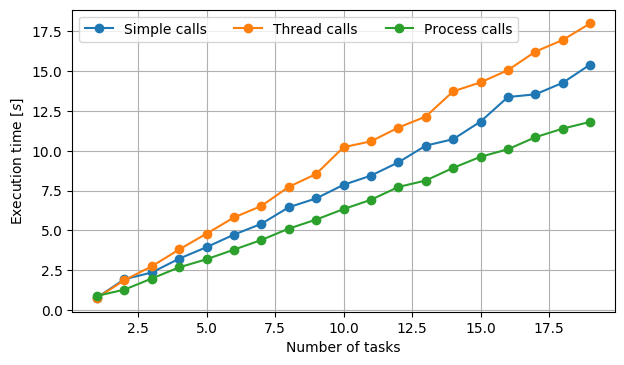

In [313]:
calls = range(1, 20, 1)

simple_calls = []
thread_calls = []
process_calls = []

for i in calls:

    t0 = time.time()
    [long_funtion() for i in range(i)]
    t1 = time.time()
    simple_calls.append(t1-t0)
    
    t0 = time.time()
    stuffs = [Thread(target=long_funtion) for i in range(i)]
    [stuf.start() for stuf in stuffs]
    [stuf.join() for stuf in stuffs]
    t1 = time.time()
    thread_calls.append(t1-t0)
    
    t0 = time.time()
    stuffs = [Process(target=long_funtion) for i in range(i)]
    [stuf.start() for stuf in stuffs]
    [stuf.join() for stuf in stuffs]
    t1 = time.time()
    process_calls.append(t1-t0)
    
plt.figure(figsize=(7, 4), dpi=100)
plt.plot(calls, simple_calls, '-o', label='Simple calls')
plt.plot(calls, thread_calls, '-o', label='Thread calls')
plt.plot(calls, process_calls, '-o', label='Process calls')
plt.grid(True)
plt.xlabel('Number of tasks')
plt.ylabel('Execution time [$s$]')

plt.legend(ncol=3)
plt.savefig('images/threadvsprocessing.jpg')
plt.show()

Podemos ver un rendimiento lineal, las tareas se demoran menos cuando se distribuyen por todos los procesadores disponibles lo cual es el resultado esperado, sin embargo parece que es mejor usar llamados simples que ejecutarlos en hilos, la razón es muy sencilla, y es que como ya se había mencionado, los hilos usan interrupciones y estas no son inmediatas, hay una pequeña pausa entre la interrupción de una tarea y la continuación de otra, todas esas pausas se acumulan y se suman al tiempo de ejecución.

# Conclusión

Hay muchas características propias de cada método, no se trata de elegir el que aparenta ser mas rápido, ejecutar múltiples hilos en el mismo procesador tiene una ventaja muy grande a la hora de intercambiar información, podemos compartir estructuras de datos de una forma muy sencilla y rápida, es entendible que compartir datos entre procesadores sea una tarea un poco mas compleja y aunque es posible usar colas especiales la velocidad de lectura y escritura se verá comprometida, este es el factor decisorio principal a la hora de elegir el método que mas nos convenga en nuestro desarrollo.  

La mayoría de las veces si tenemos un desarrollo muy complejo la mejor solución es usar ambas técnicas y elegir correctamente los trabajos que ejecutaremos en hilos o en procesos, en mi experiencia tareas como adquisición y procesamiento en tiempo real es mejor ejecutarlas en múltiples hilos en el mismo procesador, luego, en los procesadores restantes implementar servidores para streamming, validaciones, APIs.